# Streamlining making maps with different $C_\ell^\beta$

In [2]:
#set up values and functions
#------packages-------------------
%pylab inline

import healpy as hp

#-------constants------------------
TCMB = 2.7255  # Kelvin
hplanck = 6.626070150e-34  # MKS
kboltz = 1.380649e-23  # MKS


#-------functions------------------
#defines the ell power law that we will use for the A_s spectrum
def powerlaw(ell, alpha):
    return (ell/ 80.)**alpha

#defines a normal planck distribution 
def normed_cmb_thermo_units(nu):
    X = hplanck * nu / (kboltz * TCMB)
    eX = np.exp(X)
    return eX * X**4 / (eX - 1.)**2

#define the synchrotron SED.
#define what frequency map we want to look at. Start with 2.3 GHz
nu0 = 2.3e9 

def normed_synch(nu, beta):
    if beta is not np.array:
        beta = np.array(beta)
    return (nu/nu0)**(2.+beta[..., np.newaxis])

def scale_synch(nu, beta):
    unit = normed_synch(nu, beta) * normed_cmb_thermo_units(nu0) / normed_cmb_thermo_units(nu)
    return unit


#-------BB parameters (to start)--------
A_BB = 1.7e3
alpha_BB = -3.0
beta_BB = -3.2

#-------map paramters--------------------
nside = 128
Lmax = 384
ells = np.arange(1,Lmax+1)

Populating the interactive namespace from numpy and matplotlib


In [3]:
"""
----Notation used in this notebook----

ells    - the ells up to ell_max = 384
pcls    - the power law C_ell defined through pcls = (ell/80)^alpha_BB
check_cls - the extracted C_ell from a map using anafast

sbb     - the power law map in ell. This will be used for all complete maps, as we're only modifying the frequency dep.


sed_scaling_<x> - the scaled_synch function on frequencies and some beta. Up to unit conversion this is (nu/nu_0)^beta
                  where beta is either just a constant or is a whole map of betas


newmaps_<x>    - newmaps_<x> = sbb * sed_scaling_<x>. This is a series of 'real' frequency maps

""";

In [4]:
#----input power spectrum---
#define C_ell with a power law dependence on ell
pcls = A_BB * powerlaw(ells, alpha_BB)
pcls[0] = 0 
pcls[1] = 0
ells = ells -1. #shift the ells to start at 0

#produce power law map
sbb = hp.synfast(pcls, nside, new=True)

#now extract the power spectrum (the C_ells) from the map
check_cls = hp.anafast(sbb)

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


In [5]:
#----produce the SED------------
#define list of frequencies going from 10 to 300 GHz, sampling 20 points
freqs = np.linspace(10,300,20)*1.e9

#define the SED scaling (constant beta)
sed_scaling_const = scale_synch(freqs, beta_BB)

#the maps including SED at different frequencies
newmaps_const = sbb * sed_scaling_const[..., np.newaxis]

In [6]:
#----define different beta maps-----


#----flat power spectrum of beta----
#-----------------------------------
beta_sigma = 1.5e-6

beta_cls_uniform = beta_sigma * ones_like(ells)
beta_map_uniform = hp.synfast(beta_cls_uniform, nside, new=True)
beta_map_uniform -= (np.mean(beta_map_uniform) + 3.2) #update the map so that the mean is correct

#check beta_cls from this map compared to input (uniform spectrum)
check_bcls_uniform = hp.anafast(beta_map_uniform)

#define the new, varying SED
sed_scaling_uniform = scale_synch(freqs, beta_map_uniform).T 

#the maps formed so far from the beta stuff do not include A_s, so must multiply by sbb
newmaps_uniform = sbb * sed_scaling_uniform

#-----------------------------------
#
#-----------------------------------


#----random power spectrum of beta (centred on beta_sigma)----
#make c_ells centred on beta sigma but random variation around it
beta_cls_rand = beta_sigma * ones_like(ells)
noise = 1e-5*(0.5*ones_like(ells) - rand(Lmax))
beta_cls_rand += noise

beta_map_rand = hp.synfast(beta_cls_rand, nside, new=True)
beta_map_rand -= (np.mean(beta_map_rand) + 3.2)

check_bcls_rand = hp.anafast(beta_map_rand)

#new SED and map
sed_scaling_rand = scale_synch(freqs, beta_map_rand).T 
newmaps_rand = sbb * sed_scaling_rand


#-----------------------------------
#
#-----------------------------------

'''Running into problems here with a division by 0''';

# #----power law spectrum of beta (negative power)-------------
# delta1 = -2.1
# beta_cls_power1 = powerlaw(ells+1., delta1)

# beta_map_power1 = hp.synfast(beta_cls_power1, nside, new=True)
# beta_map_power1 -= (np.mean(beta_map_power1)+3.2)

# check_bcls_power1 = hp.anafast(beta_map_power1)

# #new SED and map
# sed_scaling_power1 = scale_synch(freqs, beta_map_power1).T
# newmaps_power1 = sbb * sed_scaling_power1



Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


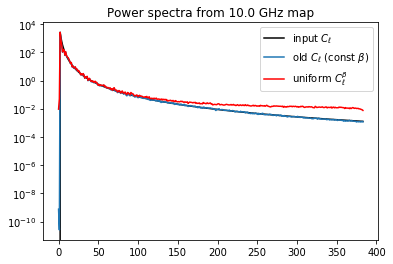

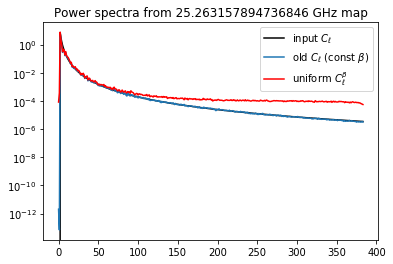

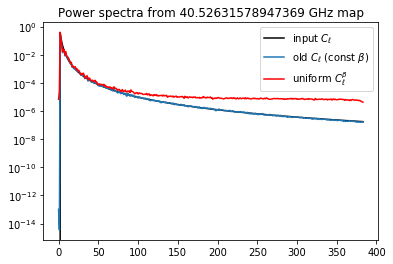

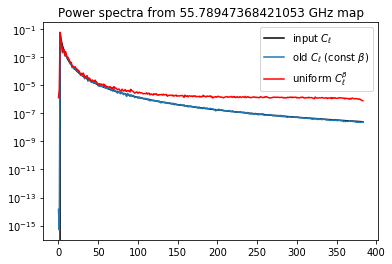

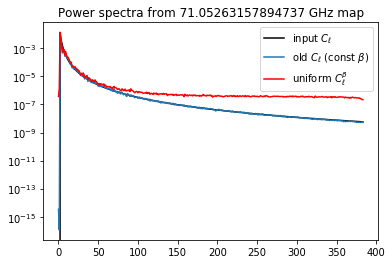

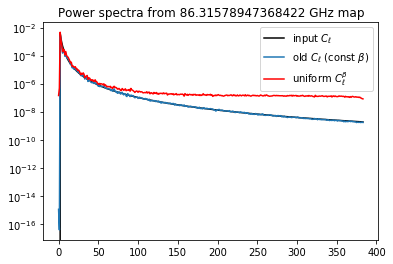

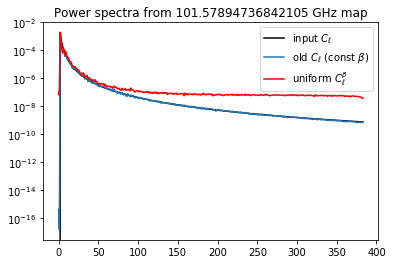

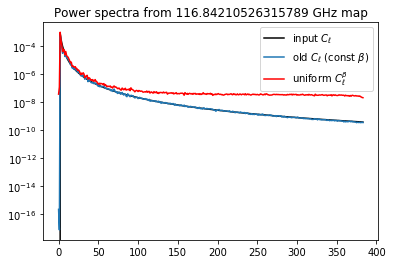

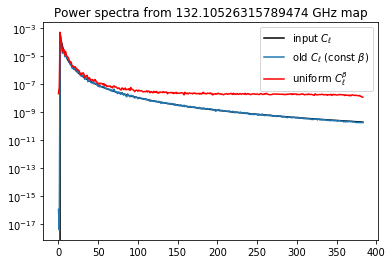

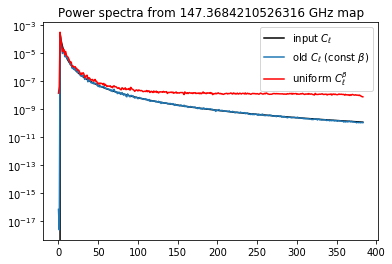

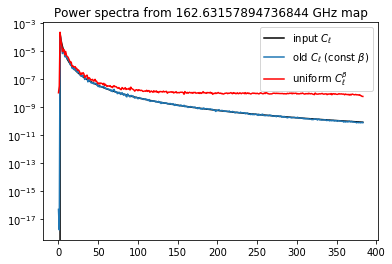

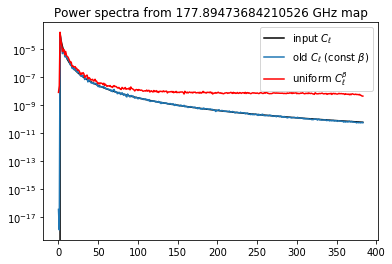

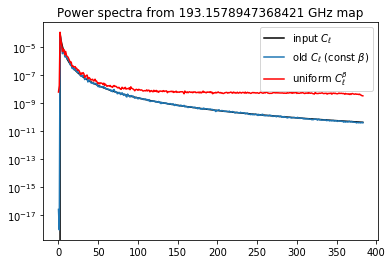

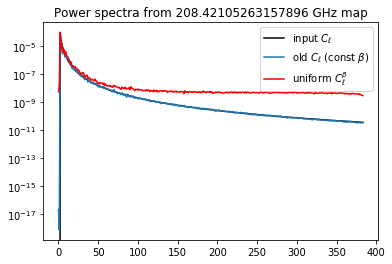

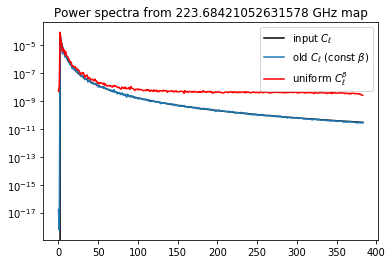

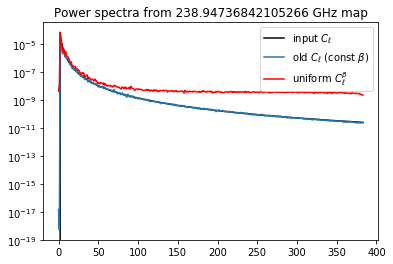

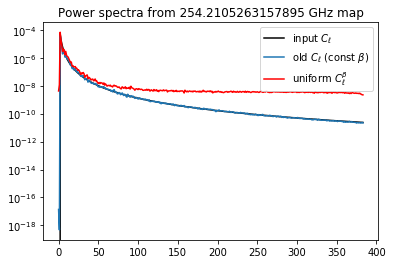

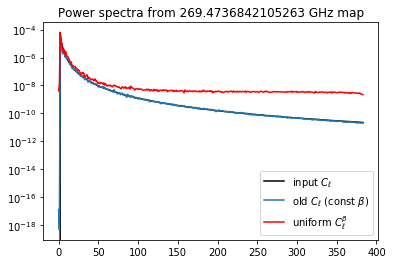

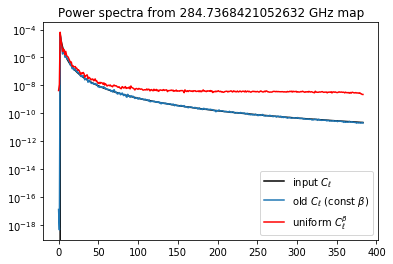

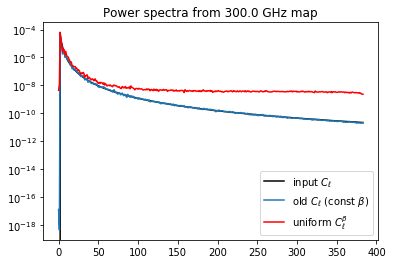

In [7]:
#----comparing power spectra to input spectra-----
#-------------------------------------------------

#----flat C_ell^beta------------------------------
for k in range(20): #can go up to 20
    figure()
    theory_cls = pcls*sed_scaling_const[k]**2     #input c_ell
    old_cls = hp.anafast(newmaps_const[k])        #the input c_ell
    new_cls = hp.anafast(newmaps_uniform[k])      #the c_ell from constant c_ell from the beta
    
    semilogy(ells, theory_cls, 'k', label=r"input $C_\ell$")
    semilogy(ells, old_cls, label=r"old $C_\ell$ (const $\beta$)")
    semilogy(ells, new_cls, 'r', label=r"uniform $C_\ell^\beta$")
    title("Power spectra from " + str(1e-9*freqs[k]) + " GHz map" )
    legend()

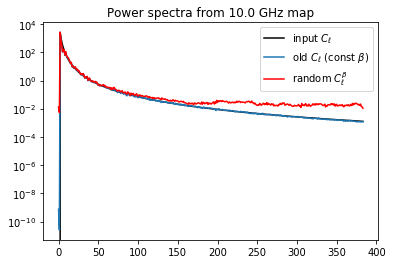

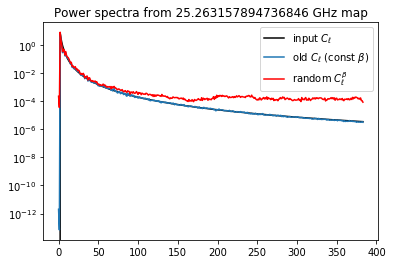

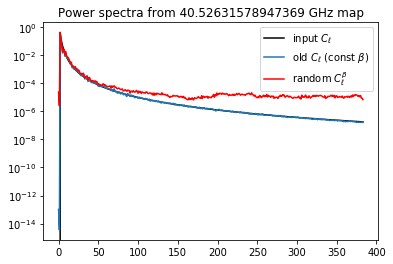

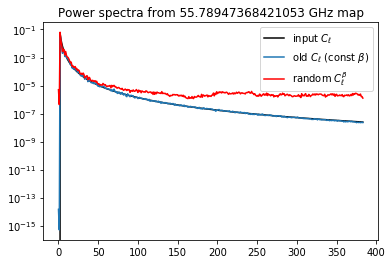

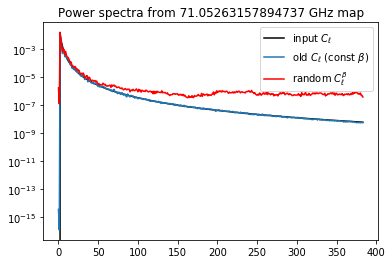

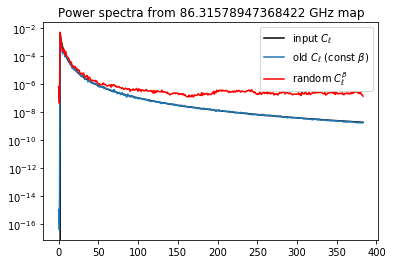

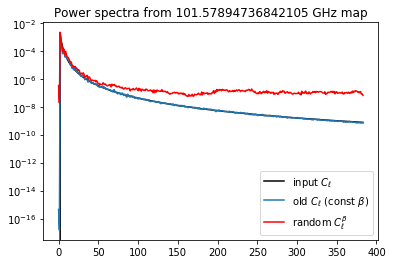

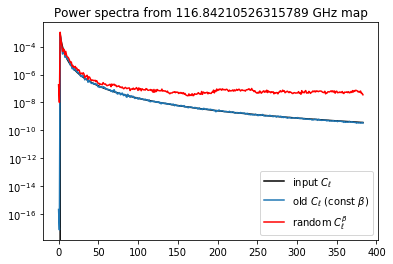

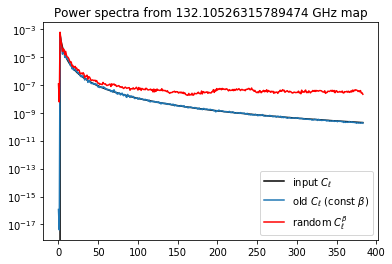

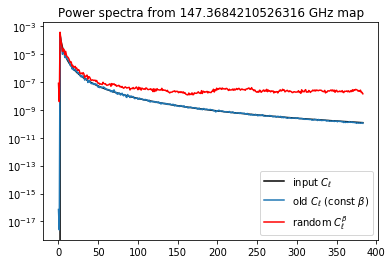

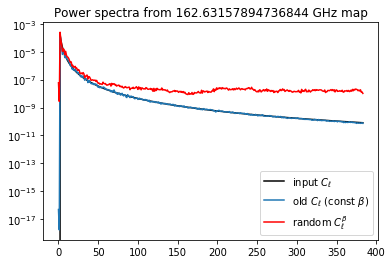

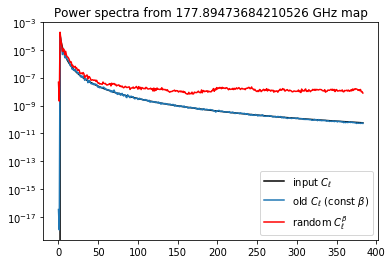

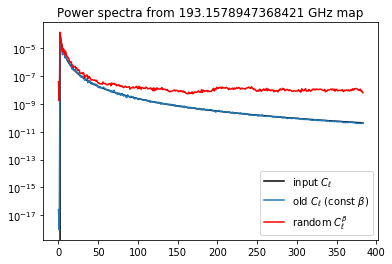

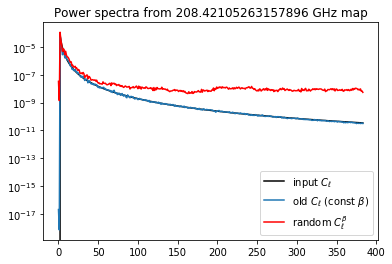

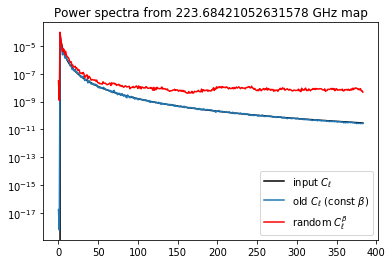

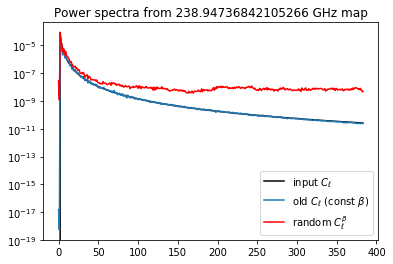

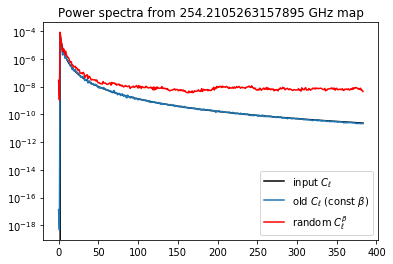

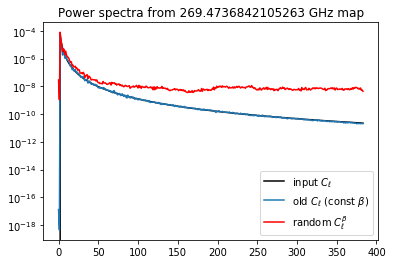

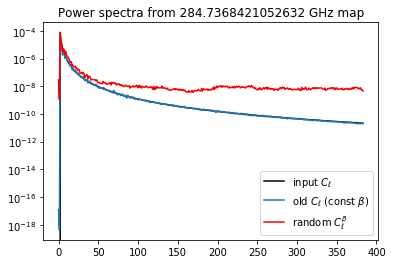

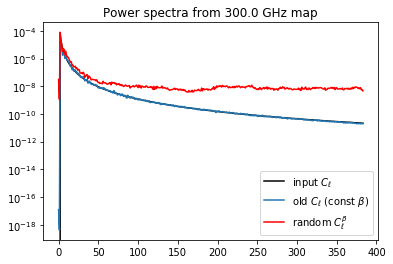

In [8]:
#----comparing power spectra to input spectra-----
#-------------------------------------------------

#----noisy C_ell^beta------------------------------
for k in range(20): #can go up to 20
    figure()
    theory_cls = pcls*sed_scaling_const[k]**2     #input c_ell
    old_cls = hp.anafast(newmaps_const[k])        #the input c_ell
    new_cls = hp.anafast(newmaps_rand[k])      #the c_ell from random c_ell from the beta
    
    semilogy(ells, theory_cls, 'k', label=r"input $C_\ell$")
    semilogy(ells, old_cls, label=r"old $C_\ell$ (const $\beta$)")
    semilogy(ells, new_cls, 'r', label=r"random $C_\ell^\beta$")
    title("Power spectra from " + str(1e-9*freqs[k]) + " GHz map" )
    legend()